In [55]:
import pandas as pd  
import numpy as np 
import math
import sys
import matplotlib.pyplot as plt  
import seaborn as sns
import seaborn as seabornInstance 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
from sklearn import metrics
%matplotlib inline

In [56]:
temp='2m Temperature (hr. avg) (F)'

In [57]:
data = pd.read_csv('200258470.csv')[temp]

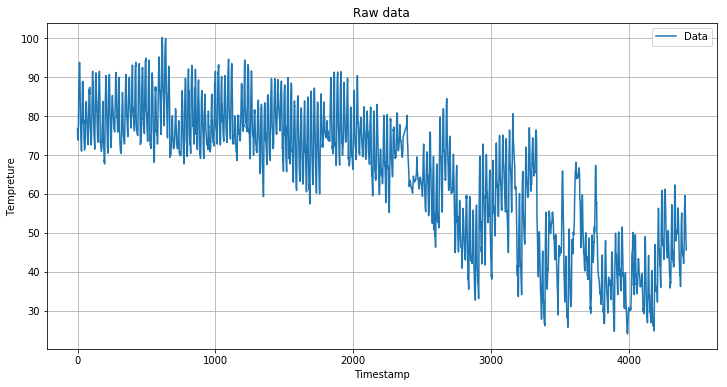

In [58]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Data')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("Raw data")
plt.show()

([<matplotlib.axis.XTick at 0x242497cc668>,
 <a list of 21 Text xticklabel objects>)

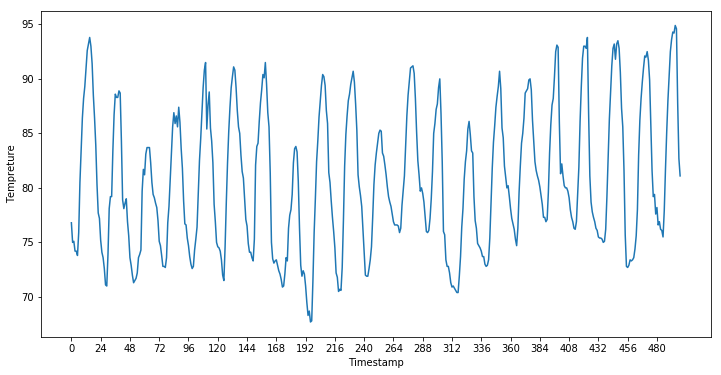

In [59]:
plt.figure(figsize=(12,6))
a=sns.lineplot(data=data[:500])
a.set(xlabel='Timestamp', ylabel='Tempreture')
plt.xticks(np.arange(0,len(data[:500]),step=24))
#plt.plot(rolmean, color='red', label='Rolling Mean')
#plt.plot(rolstd, color='black', label = 'Rolling Std')

In [60]:
#differencing method
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [61]:
#removing seasonality and  trend using seasonal differencing
dataset = difference(data,24)

Text(0.5, 1.0, 'Dataset after applying seasonal differencing')

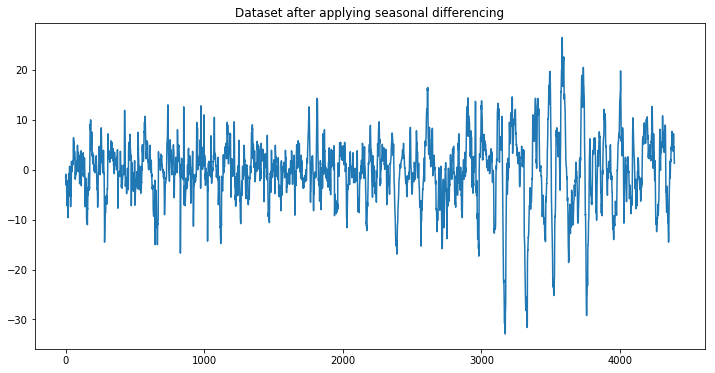

In [62]:
plt.figure(figsize=(12,6))
plt.plot(dataset)
plt.title("Dataset after applying seasonal differencing")
#plt.xticks(np.arange(0,len(dataset[:500]),step=24))

In [63]:
#divide the data into training and test sets
midpoint = len(dataset)//2
#print(midpoint)
train = dataset[:midpoint]
test = dataset [midpoint:]

In [64]:
#calculating the error
def calculate_error(true,pred):
    return true-pred

In [65]:
#Simple moving average
def simple_moving_average(data,k):
    return (data.rolling(window=k).mean())

In [66]:
def calculate_rmse(true,pred):
    return sqrt(mean_squared_error(true, pred))

In [67]:
windows=100
sma_rmse=[]
k_values=list(range(2,windows,1))
min_rsme=sys.maxsize
min_k=-1
for k in k_values:
    sma=simple_moving_average(train,k)
    true= train[k:]
    pred=sma[k:]
    error = calculate_error(true,pred)
    rmse =  calculate_rmse(true,pred)
    if(rmse<min_rsme):
        min_rsme=rmse
        min_k=k
    sma_rmse.append(rmse)

Text(0.5, 1.0, 'RMSE VS k')

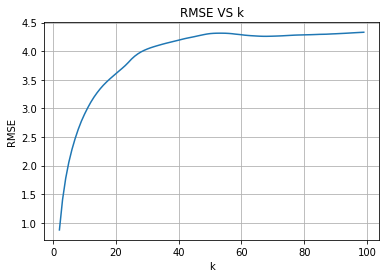

In [68]:
fig4=plt.figure()
plt.plot(k_values, sma_rmse)
plt.grid()
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title("RMSE VS k")

In [69]:
print(min_k)
print(min_rsme)

2
0.8762014800993833


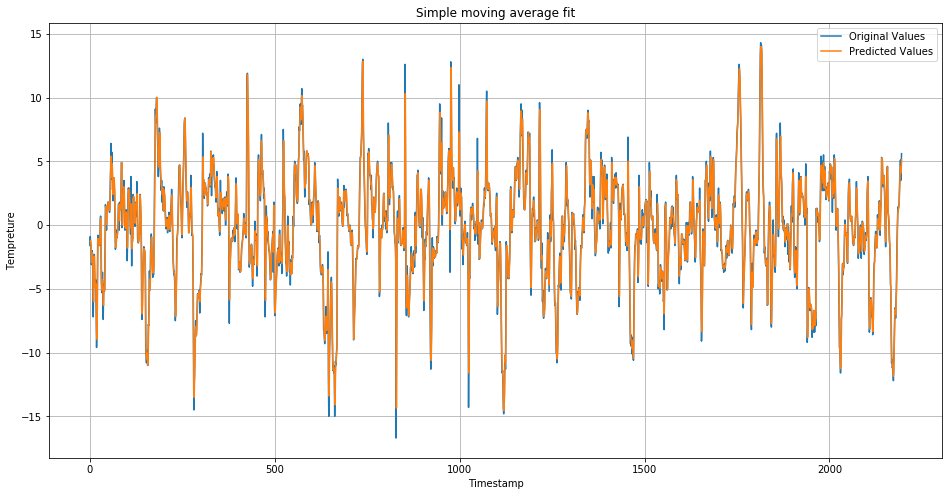

In [70]:
pred_sma= simple_moving_average(train,min_k)
plt.figure(figsize=(16,8))
plt.plot(train, label='Original Values')
plt.plot(pred_sma, label='Predicted Values')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("Simple moving average fit")
plt.show()

In [71]:
def exponential_smoothing(train,alpha):
    #print(alpha)
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha,optimized=False)
    return(model.predict(0,len(train)-1))

In [72]:
import sys
sem_rmse=[]
a_values=[x/10 for x in range(1, 10)]
min_rsme=sys.maxsize
min_a=-1
for a in a_values:
    pred = exponential_smoothing(train,a)
    error = calculate_error(train,pred)
    rmse =  calculate_rmse(train,pred)
    if(rmse<min_rsme):
        min_rsme=rmse
        min_a=a
    sem_rmse.append(rmse)

In [73]:
print(min_rsme)
print(min_a)

1.7927578306118268
0.9


Text(0.5, 1.0, 'RMSE VS alpha')

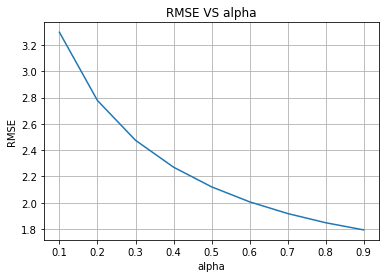

In [74]:
fig4=plt.figure()
plt.plot(a_values, sem_rmse)
plt.grid()
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title("RMSE VS alpha")

In [75]:
model_expo_smoothing = SimpleExpSmoothing(train).fit(smoothing_level=min_a,optimized=False)
prediction_exsm = model_expo_smoothing.predict(0,len(train)-1)
rmse_exponential_train =  calculate_rmse(train,prediction_exsm)
print(rmse_exponential_train)

1.7927578306118268


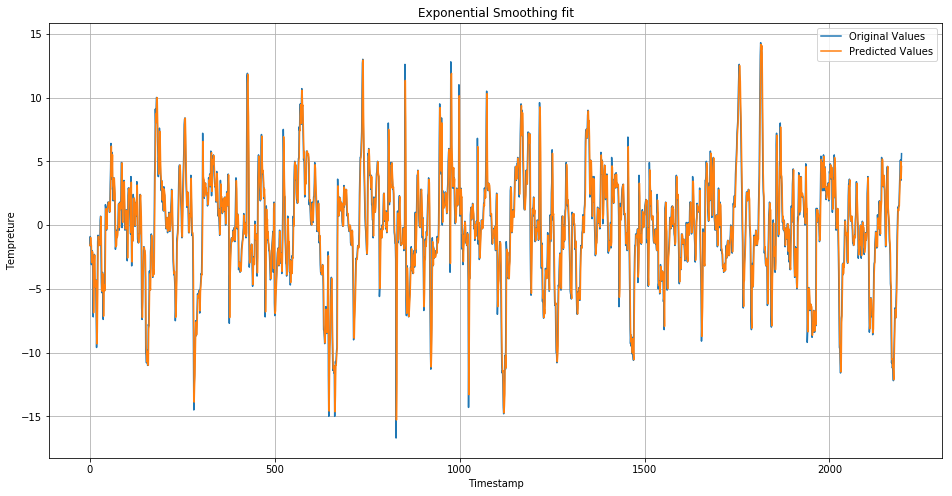

In [76]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Original Values')
plt.plot(prediction_exsm , label='Predicted Values')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("Exponential Smoothing fit")
plt.show()

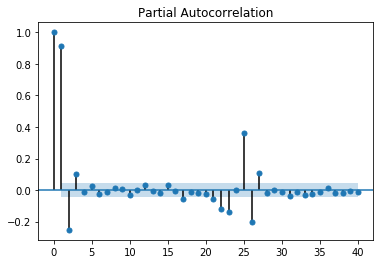

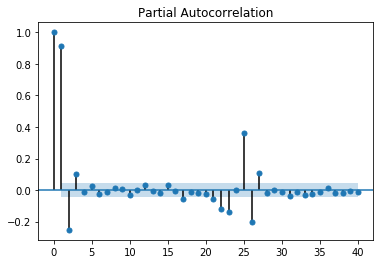

In [77]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train,lags=40, title='Partial Autocorrelation')

In [78]:
from statsmodels.tsa.stattools import pacf
delta = 0.15
lag_pacf = pacf(train, nlags=40, method='yw')
p=-1;
for i in range(0,len(lag_pacf)):
    if abs(lag_pacf[i]) <= delta:
        p = i-1
        break
print("Oder p: " )
print(p)

Oder p: 
2


In [79]:
from statsmodels.tsa.ar_model import AR

In [80]:
def AR_model(data,p):
    model = AR(data)
    mod_fit= model.fit(p) 
    return (mod_fit)

In [81]:
print(p)
model_AR= AR_model(train,p)
pred_ar=model_AR.predict(p,len(train)-1)
print(model_AR.params)
resid=model_AR.resid

2
const   -0.017157
L1.y     1.143532
L2.y    -0.252912
dtype: float64


In [82]:
ar_rmse = calculate_rmse(train[p:],pred_ar)
print(ar_rmse)

1.6583028315260246


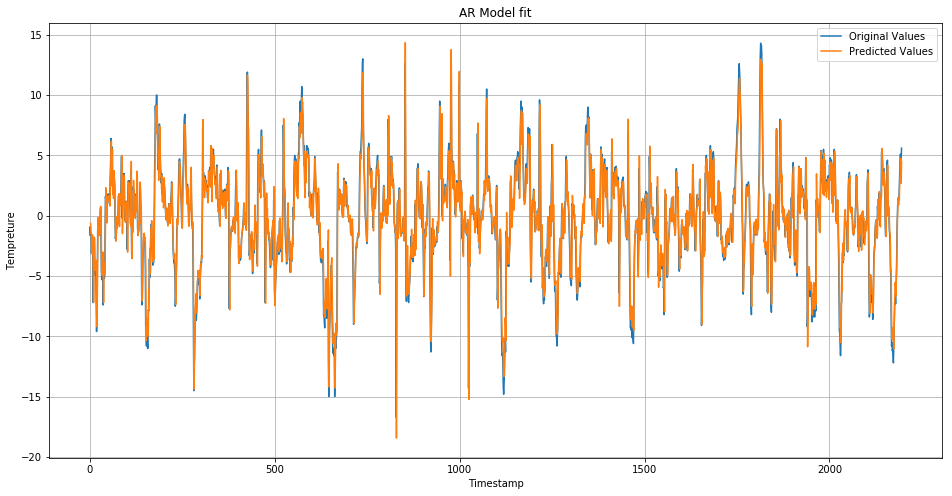

In [86]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Original Values')
plt.plot(pred_ar , label='Predicted Values')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("AR Model fit")
plt.show()

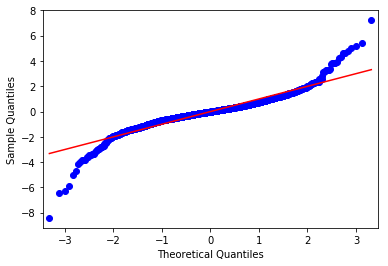

In [87]:
import scipy.stats as stats
fig = sm.qqplot(resid,stats.norm, fit=True, line='s')
plt.show()

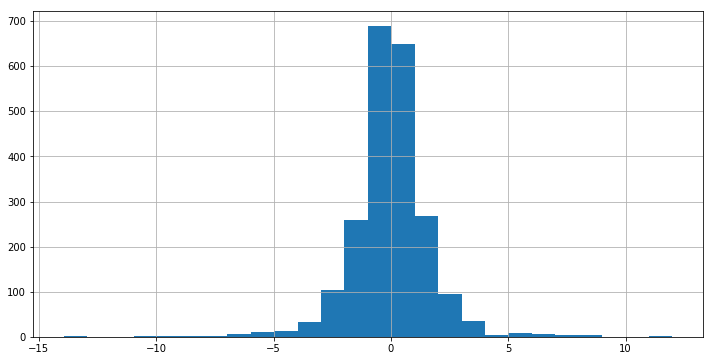

In [88]:
resid.hist(figsize=(12,6),bins=26)

No handles with labels found to put in legend.


[Text(0, 0.5, 'Residual'), Text(0.5, 0, 'Y prediction')]

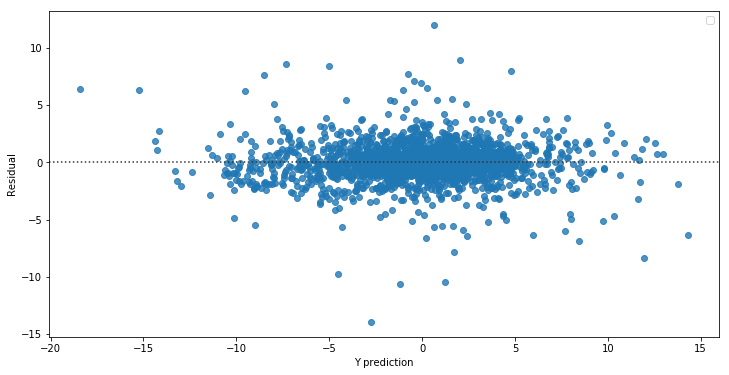

In [89]:
ress= resid.to_frame()
plt.figure(figsize=(12,6))
plt.legend(loc='best')
g=sns.residplot(pred_ar,ress,label="prediction vs residual ")
g.set(xlabel='Y prediction', ylabel='Residual')

In [90]:
ress.to_csv("residuals_forecasting.csv")

In [91]:
#Simple moving average 
sma=simple_moving_average(test,min_k)
true= test[min_k:]
pred_sma_test=sma[min_k:]
rmse_sma_test =  calculate_rmse(true,pred_sma_test)
print(rmse_sma_test)

0.8402634905106813


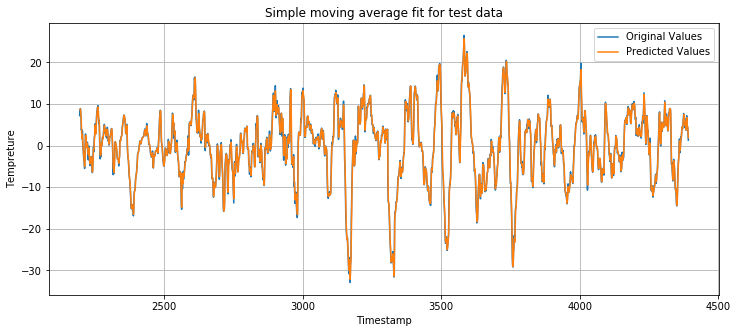

In [92]:
pred_sma= simple_moving_average(train,min_k)
plt.figure(figsize=(12,5))
plt.plot(test, label='Original Values')
plt.plot(pred_sma_test, label='Predicted Values')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("Simple moving average fit for test data")
plt.show()

In [93]:
model_expo_smoothing = SimpleExpSmoothing(test).fit(smoothing_level=min_a,optimized=False)
prediction_exsm_test = model_expo_smoothing.predict(0,len(test)-1)
rmse_exponential_test =  calculate_rmse(test,prediction_exsm_test)
print(rmse_exponential_test)

1.763624701224551


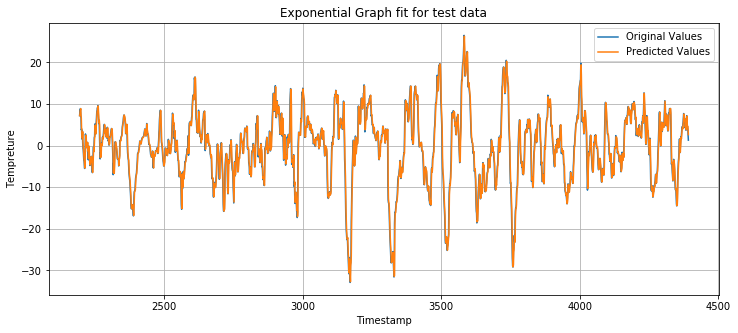

In [94]:
plt.figure(figsize=(12,5))
plt.plot(test, label='Original Values')
plt.plot(prediction_exsm_test, label='Predicted Values')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("Exponential Graph fit for test data")
plt.show()

In [95]:
#AR model
model= AR_model(test,p)
pred_ar_test=model.predict(p,len(test)-1)
rmse =  calculate_rmse(test[p:],pred_ar_test)
print(rmse)

1.4875094900690058


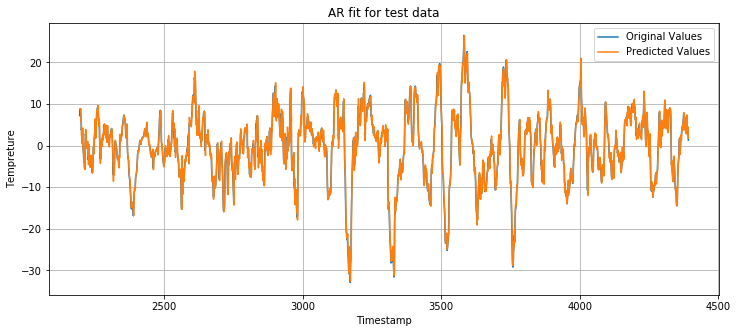

In [96]:
plt.figure(figsize=(12,5))
plt.plot(test, label='Original Values')
plt.plot(pred_ar_test, label='Predicted Values')
plt.legend(loc='best')
plt.xlabel("Timestamp")
plt.ylabel("Tempreture")
plt.grid()
plt.title("AR fit for test data")
plt.show()